In [1]:
from tqdm import tqdm
import torchvision
import torch as t
from torch.utils.data import DataLoader
from preprocess import collate_fn, test_collate_fn
import os
from datetime import datetime
import numpy as np

import import_ipynb
from Ladder_GNP import get_model

import matplotlib.pyplot as plt
%matplotlib inline

importing Jupyter notebook from Ladder_GNP.ipynb


In [2]:
def plot_img(model, dloader):
    fig = plt.figure()
    model.eval()
    for i, d in enumerate(dloader):
        context_x, context_y, target_x, target_y = d
        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        pred_y, _, _ = model(context_x, context_y, target_x, None) # Test

        #fig.add_subplot(1,2,1)
        #fig.add_subplot(1,2,2)
        subplot = fig.add_subplot(1, 2, 1)
        subplot.axis('off')
        subplot.imshow(target_y.squeeze(0).view(-1,28).detach().numpy(), cmap='gray')
        subplot = fig.add_subplot(1, 2, 2)
        subplot.axis('off')
        subplot.imshow(pred_y.cpu().squeeze(0).view(-1,28).detach().numpy(), cmap='gray')

        if i == 1:
            break
    plt.show()

In [3]:
def main(model_name = 'LGNP'):
    train_dataset = torchvision.datasets.MNIST('./mnist', train=True, download=False)
    data_len = len(train_dataset)
    test_dataset = torchvision.datasets.MNIST('./mnist', train=False, download=True)
    test_data_len = len(test_dataset)
    epochs = 100001
    PLOT_AFTER = 10000
    model = get_model().cuda()
    model.train()
    
    optim = t.optim.Adam(model.parameters(), lr=1e-4)
    global_step = 0
    start = datetime.now()    
    for epoch in range(epochs):
        np.random.seed(epoch)
        indices = np.random.choice(range(data_len), 16, replace=False)
        dataset = t.utils.data.Subset(train_dataset, indices)
        dloader = DataLoader(dataset, batch_size=16, collate_fn=collate_fn, shuffle=False, num_workers=0)
        #pbar = tqdm(dloader)
        for i, data in enumerate(dloader):
            global_step += 1
            context_x, context_y, target_x, target_y = data
            context_x = context_x.cuda()
            context_y = context_y.cuda()
            target_x = target_x.cuda()
            target_y = target_y.cuda()
            model.train()
            # pass through the latent model
            y_pred, kl, loss = model(context_x, context_y, target_x, target_y)
            
            # Training step
            optim.zero_grad()
            loss.backward()
            optim.step()
                
        if epoch % PLOT_AFTER == 0:
            elapsed = (datetime.now() - start).total_seconds()
            # save model by each epoch    
            print('Iteration: {}, loss: {:.5f}, time: {:.5f}'.format(epoch, loss, elapsed))
            t.save({model_name:model.state_dict(),
                                     'optimizer':optim.state_dict()},
                                    os.path.join('./checkpoint','%s_%d.pth.tar' % (model_name, epoch+1)))
            np.random.seed(epoch)
            tindices = np.random.choice(range(test_data_len), 1, replace=False)
            tdataset = t.utils.data.Subset(test_dataset, tindices)
            tdloader = DataLoader(tdataset, batch_size=1, collate_fn=test_collate_fn, shuffle=False, num_workers=0)
            plot_img(model, tdloader)
            model.train()

Iteration: 0, loss: 0.73545, time: 0.59361


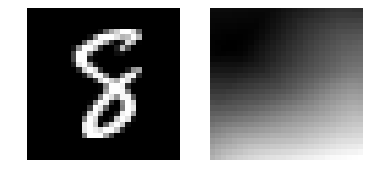

Iteration: 10000, loss: -0.58424, time: 3169.65294


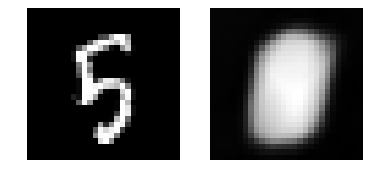

Iteration: 20000, loss: -0.74379, time: 6318.01179


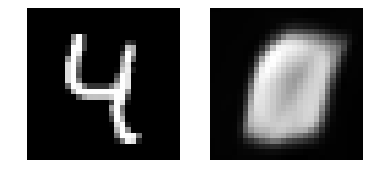

Iteration: 30000, loss: -0.69218, time: 9476.14383


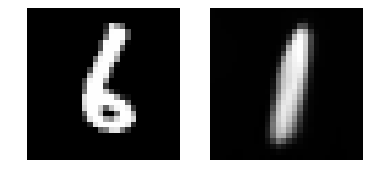

Iteration: 40000, loss: -0.73902, time: 13503.95111


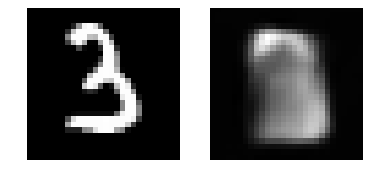

Iteration: 50000, loss: -0.72805, time: 17551.33263


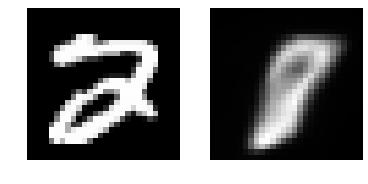

Iteration: 60000, loss: -0.64053, time: 21589.84794


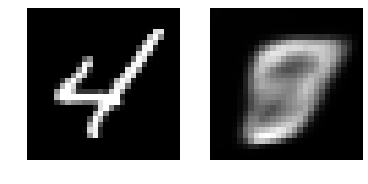

Iteration: 70000, loss: -0.71220, time: 25646.54009


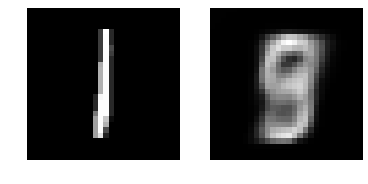

Iteration: 80000, loss: -0.81709, time: 29704.09334


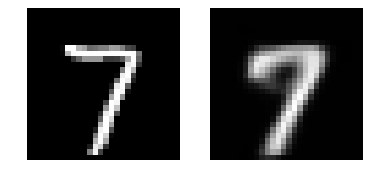

Iteration: 90000, loss: -0.80151, time: 33766.52272


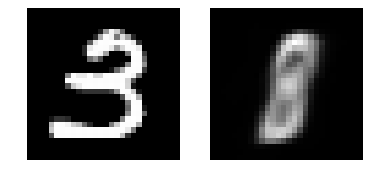

Iteration: 100000, loss: -0.82855, time: 37812.93473


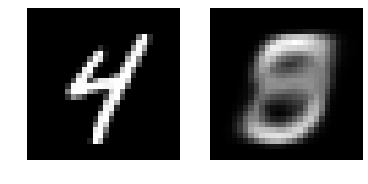

In [4]:
if __name__ == '__main__':
    main()